In [1]:
'''
기본적인 Pytorch Module 들을 import 한다.
torch는 1.12.1
'''
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from torch import einsum
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from einops import rearrange, repeat
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator #Pytorch-Ignite를 통해서 model을 훈련시키고 업데이트 하는 과정을 단순화 시킨다. 
import ignite.metrics
import ignite.contrib.handlers

In [2]:
DATA_DIR='./data'  #data path 지정

IMAGE_SIZE = 32 #Imgae Size 지정, Cifar10이니 이미지 Size 32

NUM_CLASSES = 10 #cifar10이니 10개의 클래스, cifar100이면 100, IMAGENET-1k는 1000
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #Cuda 사용
#사용 GPU는 Tesla V100 32G
print("device:", DEVICE)

device: cuda


Files already downloaded and verified
Files already downloaded and verified


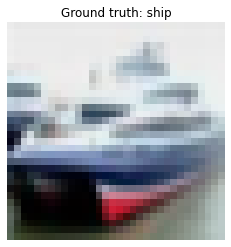

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)#dataset 준비
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

def dataset_show_image(dset, idx): #dataset속 data 확인하는 함수 
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()
    
dataset_show_image(test_dset, 1)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [6]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean(dim=-2)

In [7]:
class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0):
        super().__init__()
        self.heads = dim // head_dim
        self.head_dim = head_dim
        self.scale = head_dim**-0.5
        
        self.shape = shape
        self.window_size = window_size
        self.shift_size = shift_size
        
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.unifyheads = nn.Linear(dim, dim)
        
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * window_size - 1)**2))
        self.register_buffer("relative_indices", self.get_indices(window_size))
        
        if shift_size > 0:
            self.register_buffer("mask", self.generate_mask(shape, window_size, shift_size))
    
    
    def forward(self, x):
        shift_size, window_size = self.shift_size, self.window_size
        
        x = self.to_windows(x, self.shape, window_size, shift_size) # partition into windows
        
        # self attention
        qkv = self.to_qkv(x).unflatten(-1, (3, self.heads, self.head_dim)).transpose(-2, 1)
        queries, keys, values = qkv.unbind(dim=2)
        
        att = queries @ keys.transpose(-2, -1)
        
        att = att * self.scale + self.get_rel_pos_enc(window_size) # add relative positon encoding
        
        # masking
        if shift_size > 0:
            att = self.mask_attention(att)
        
        att = F.softmax(att, dim=-1)
        
        x = att @ values
        x = x.transpose(1, 2).contiguous().flatten(-2, -1) # move head back
        x = self.unifyheads(x)
        
        x = self.from_windows(x, self.shape, window_size, shift_size) # undo partitioning into windows
        return x
    
    
    def to_windows(self, x, shape, window_size, shift_size):
        x = x.unflatten(1, shape)
        if shift_size > 0:
            x = x.roll((-shift_size, -shift_size), dims=(1, 2))
        x = self.split_windows(x, window_size)
        return x
    
    
    def from_windows(self, x, shape, window_size, shift_size):
        x = self.merge_windows(x, shape, window_size) 
        if shift_size > 0:
            x = x.roll((shift_size, shift_size), dims=(1, 2))
        x = x.flatten(1, 2)
        return x
    
    
    def mask_attention(self, att):
        num_win = self.mask.size(1)
        att = att.unflatten(0, (att.size(0) // num_win, num_win))
        att = att.masked_fill(self.mask, float('-inf'))
        att = att.flatten(0, 1)
        return att
    
    
    def get_rel_pos_enc(self, window_size):
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (window_size**2, window_size**2))
        return rel_pos_enc
    
    
    # For explanation of mask regions see Figure 4 in the article
    @staticmethod
    def generate_mask(shape, window_size, shift_size):
        region_mask = torch.zeros(1, *shape, 1)
        slices = [slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None)]
        
        region_num = 0
        for i in slices:
            for j in slices:
                region_mask[:, i, j, :] = region_num
                region_num += 1

        mask_windows = ShiftedWindowAttention.split_windows(region_mask, window_size).squeeze(-1)
        diff_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        mask = diff_mask != 0
        mask = mask.unsqueeze(1).unsqueeze(0) # add heads and batch dimension
        return mask
    
    
    @staticmethod
    def split_windows(x, window_size):
        n_h, n_w = x.size(1) // window_size, x.size(2) // window_size
        x = x.unflatten(1, (n_h, window_size)).unflatten(-2, (n_w, window_size)) # split into windows
        x = x.transpose(2, 3).flatten(0, 2) # merge batch and window numbers
        x = x.flatten(-3, -2)
        return x
    
    
    @staticmethod
    def merge_windows(x, shape, window_size):
        n_h, n_w = shape[0] // window_size, shape[1] // window_size
        b = x.size(0) // (n_h * n_w)
        x = x.unflatten(1, (window_size, window_size))
        x = x.unflatten(0, (b, n_h, n_w)).transpose(2, 3) # separate batch and window numbers
        x = x.flatten(1, 2).flatten(-3, -2) # merge windows
        return x
    
    
    @staticmethod
    def get_indices(window_size):
        x = torch.arange(window_size, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(x, x, x, x, indexing='ij')
        indices = (y1 - y2 + window_size - 1) * (2 * window_size - 1) + x1 - x2 + window_size - 1
        indices = indices.flatten()
        
        return indices

In [8]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, mult=4):
        hidden_dim = dim * mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)   
        )
class TransformerBlock(nn.Sequential):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0, p_drop=0.):
        super().__init__(
            Residual(
                nn.LayerNorm(dim),
                ShiftedWindowAttention(dim, head_dim, shape, window_size, shift_size),
                nn.Dropout(p_drop)
            ),
            Residual(
                nn.LayerNorm(dim),
                FeedForward(dim),
                nn.Dropout(p_drop)
            )
        )
class PatchMerging(nn.Module):
    def __init__(self, in_dim, out_dim, shape):
        super().__init__()
        self.shape = shape
        self.norm = nn.LayerNorm(4 * in_dim)
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)
    
    def forward(self, x):
        x = x.unflatten(1, self.shape).movedim(-1, 1)
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)
        
        x = self.norm(x)
        x = self.reduction(x)
        return x        

In [9]:
class Stage(nn.Sequential):
    def __init__(self, num_blocks, in_dim, out_dim, head_dim, shape, window_size, p_drop=0.):
        if out_dim != in_dim:
            layers = [PatchMerging(in_dim, out_dim, shape)]
            shape = (shape[0] // 2, shape[1] // 2)
        else:
            layers = []
        
        shift_size = window_size // 2
        layers += [TransformerBlock(out_dim, head_dim, shape, window_size, 0 if (num % 2 == 0) else shift_size,
                                    p_drop) for num in range(num_blocks)]
        
        super().__init__(*layers)
class StageStack(nn.Sequential):
    def __init__(self, num_blocks_list, dims, head_dim, shape, window_size, p_drop=0.):
        layers = []
        in_dim = dims[0]
        for num, out_dim in zip(num_blocks_list, dims[1:]):
            layers.append(Stage(num, in_dim, out_dim, head_dim, shape, window_size, p_drop))
            if in_dim != out_dim:
                shape = (shape[0] // 2, shape[1] // 2)
                in_dim = out_dim
        
        super().__init__(*layers)

In [10]:
class ToPatches(nn.Module):
    def __init__(self, in_channels, dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * patch_size**2
        self.proj = nn.Linear(patch_dim, dim)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        x = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size).movedim(1, -1)
        x = self.proj(x)
        x = self.norm(x)
        return x
class AddPositionEmbedding(nn.Module):
    def __init__(self, dim, num_patches):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(num_patches, dim))
    
    def forward(self, x):
        return x + self.pos_embedding
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, dim, patch_size, num_patches, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, dim, patch_size),
            AddPositionEmbedding(dim, num_patches),
            nn.Dropout(p_drop)
        )

In [11]:
class Head(nn.Sequential):
    def __init__(self, dim, classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            nn.GELU(),
            GlobalAvgPool(),
            nn.Dropout(p_drop),
            nn.Linear(dim, classes)
        )
class SwinTransformer(nn.Sequential):
    def __init__(self, classes, image_size, num_blocks_list, dims, head_dim, patch_size, window_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        num_patches = shape[0] * shape[1]
        
        super().__init__(
            ToEmbedding(in_channels, dims[0], patch_size, num_patches, emb_p_drop),
            StageStack(num_blocks_list, dims, head_dim, shape, window_size, trans_p_drop),
            Head(dims[-1], classes, head_p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, ShiftedWindowAttention):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, )
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, ShiftedWindowAttention) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [12]:
model = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,
                        num_blocks_list=[4, 4], dims=[128, 128, 256],
                        head_dim=32, patch_size=2, window_size=4,
                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)

In [13]:
"""
model = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,
                        num_blocks_list=[4, 4], dims=[128, 128, 256],
                        head_dim=32, patch_size=2, window_size=4,
                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)
                        """

'\nmodel = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,\n                        num_blocks_list=[4, 4], dims=[128, 128, 256],\n                        head_dim=32, patch_size=2, window_size=4,\n                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)\n                        '

In [14]:
from torchsummary import summary
model.to(DEVICE);
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 256, 128]           1,664
         LayerNorm-2             [-1, 256, 128]             256
         ToPatches-3             [-1, 256, 128]               0
AddPositionEmbedding-4             [-1, 256, 128]               0
           Dropout-5             [-1, 256, 128]               0
         LayerNorm-6             [-1, 256, 128]             256
            Linear-7              [-1, 16, 384]          49,536
            Linear-8              [-1, 16, 128]          16,512
ShiftedWindowAttention-9             [-1, 256, 128]               0
          Dropout-10             [-1, 256, 128]               0
         Residual-11             [-1, 256, 128]               0
        LayerNorm-12             [-1, 256, 128]             256
           Linear-13             [-1, 256, 512]          66,048
             GELU-14             

In [15]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 4,124,362


In [16]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [17]:
loss = nn.CrossEntropyLoss() #다중 Label 분류 Task에서 사용하는 loss 지정
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  #Overfitting 방지를 위해 Weight_decay 설정 및 optimizer는 AdamW로 설정 
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE) #ignite를 사용해 trainer 생성 => 쉽게 학습 
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)  #총 100번 Epoch 설정
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE) #검증을 위한 Evaluator도 생성
history = defaultdict(list)

In [18]:
"""
ignite를 사용해서 쉽게 학습 및 검증과정 수행 할 수 있음

"""
@trainer.on(Events.EPOCH_COMPLETED) #Train loss, val loss, val accuracy를 확인하기 위한 함수 정의 
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"] #train loss가 담김
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"] #val loss가 담김
    val_acc = val_metrics["accuracy"] #val acc가 담김
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

fc.weight: no difference.


In [20]:
trainer.run(train_loader, max_epochs=EPOCHS) #학습 및 검증

1/100 - train: loss 1.912; val: loss 1.896 accuracy 0.264
2/100 - train: loss 1.688; val: loss 1.620 accuracy 0.407
3/100 - train: loss 1.492; val: loss 1.454 accuracy 0.464
4/100 - train: loss 1.377; val: loss 1.394 accuracy 0.495
5/100 - train: loss 1.353; val: loss 1.288 accuracy 0.529
6/100 - train: loss 1.261; val: loss 1.308 accuracy 0.530
7/100 - train: loss 1.221; val: loss 1.160 accuracy 0.584
8/100 - train: loss 1.217; val: loss 1.157 accuracy 0.582
9/100 - train: loss 1.109; val: loss 1.148 accuracy 0.591
10/100 - train: loss 1.072; val: loss 1.053 accuracy 0.624
11/100 - train: loss 1.056; val: loss 1.055 accuracy 0.623
12/100 - train: loss 1.018; val: loss 1.007 accuracy 0.642
13/100 - train: loss 0.938; val: loss 0.940 accuracy 0.667
14/100 - train: loss 0.937; val: loss 0.919 accuracy 0.671
15/100 - train: loss 0.925; val: loss 0.886 accuracy 0.679
16/100 - train: loss 0.911; val: loss 0.859 accuracy 0.700
17/100 - train: loss 0.878; val: loss 0.833 accuracy 0.705
18/100

State:
	iteration: 156300
	epoch: 100
	epoch_length: 1563
	max_epochs: 100
	output: 0.003989569377154112
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

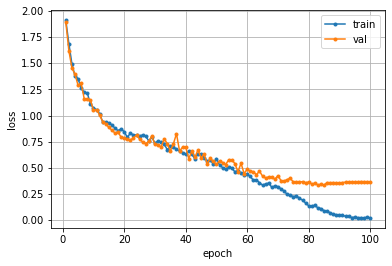

<Figure size 432x288 with 0 Axes>

In [24]:
fig = plt.figure()   #Train, Val의 loss값 확인하기 
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()
plt.savefig('./train_val_loss.png')

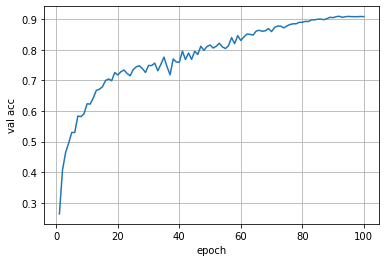

In [27]:
fig = plt.figure() #Val의 Accuracy 확인하기 
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

In [26]:
PATH = './weights/'

torch.save(model, PATH + 'model.pt')  # 전체 모델 저장

In [44]:
model_url = './weights/model.pt'
model = torch.load(model_url).cuda()
m = torch.jit.script(model)

torch.jit.save(m,'swin_transformer.pt')

RuntimeError: Can't redefine method: forward on class: __torch__.ShiftedWindowAttention (of Python compilation unit at: 0x55d650b8e0b0)

In [42]:
model_url = './weights/model.pt'
batch_size = 1    # 임의의 수
model = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,
                        num_blocks_list=[4, 4], dims=[128, 128, 256],
                        head_dim=32, patch_size=2, window_size=4,
                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)

model = torch.load(model_url).cuda()
model.eval()
batch_size = 1
x = torch.randn(batch_size, 3, 32, 32, requires_grad=True).cuda()
torch_out = model(x)
print(torch_out.shape)
# 모델 변환
torch.onnx.export(model, x, "swin_transformer.onnx", export_params=True,
                  opset_version=10, do_constant_folding=True,
                  input_names=['input'], output_names=['output'],
                  )


torch.Size([1, 10])


RuntimeError: NYI: Named tensors are not supported with the tracer